In [116]:
%matplotlib inline

In [236]:
import networkx as nx
import numpy as np
import scipy
import pandas as pd
from scipy.sparse.linalg import eigs
from sklearn.metrics import precision_recall_fscore_support

from graph_generator.community_graph import make_random_signed_graph, connect_communities
from helpers import (
    signed_layout,
    draw_nodes,
    draw_edges,
    degree_diag,
    prepare_seed_vector,
    is_rank_one,
    sbr_by_threshold,
    flatten,
    get_theoretical_kappa, 
    get_borderless_fig
)
from eval_helpers import evaluate_level_1, evaluate_level_2

In [237]:
def make_polarized_graphs(
    k, comm_sizes,
    internal_density=0.9,
    internal_neg_ratio=0.05,
    comm_cross_edge_proba=0.5,
    comm_cross_neg_ratio=0.95,
    cross_edge_proba=0.01,
    cross_neg_ratio=0.5
):
    print('#communities', k)
    assert k == len(comm_sizes)
    comms = []
    size_acc = 0
    groupings=  []
    for i, sizes in zip(range(k), comm_sizes):
        assert len(sizes) == 2
        n1, n2 = sizes
        c0 = make_random_signed_graph(n1, internal_density, internal_neg_ratio)
        c1 = make_random_signed_graph(n2, internal_density, internal_neg_ratio)
        c, groups = connect_communities([c0, c1], edge_proba=comm_cross_edge_proba, neg_ratio=comm_cross_neg_ratio)
        print('comm#{} sizes: {} {}'.format(i+1, c0.number_of_nodes(), c1.number_of_nodes()))
        groups = np.asarray(groups)
        groups += size_acc
        groupings.append(groups.tolist())
        comms.append(c)
        size_acc += c.number_of_nodes()

    g, comms = connect_communities(comms, edge_proba=cross_edge_proba, neg_ratio=cross_neg_ratio)

    return g, comms, groupings

In [238]:
random.seed(12345)
np.random.seed(12345)

size = 10
k = 2 
g, true_comms, true_groupings = make_polarized_graphs(k, [(size, size) for i in range(k)])
A = nx.adj_matrix(g, weight='sign')

#communities 2
comm#1 sizes: 10 10
comm#2 sizes: 10 10


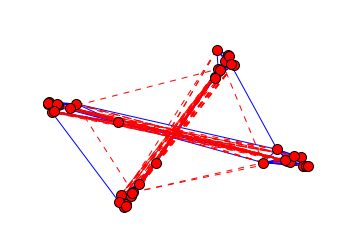

In [239]:
fig, ax = get_borderless_fig()
pos = signed_layout(g)
# draw_nodes(g, pos)
nx.draw_networkx_nodes(g, pos, node_size=100, ax=ax)
draw_edges(g, pos, ax=ax)

In [240]:
# solve the SDP program

import cvxpy as cp
from helpers import signed_laplacian

def query_graph(g, seeds, kappa=0.25, verbose=0):
    n = g.number_of_nodes()
    L = signed_laplacian(g).A
    D = degree_diag(g).A

    s = prepare_seed_vector(seeds, D)

    # requirement check 
    _, v1 = eigs(np.real(L), k=1, which='SM')
    assert not np.isclose((s.T @ np.real(v1))[0, 0], 0)

    DsDsT = (D @ s) @ (D @ s).T

    X = cp.Variable((n, n))
    constraints = [
        X >> 0,
        cp.trace(D @ X) == 1,
        cp.trace(DsDsT @ X) >= kappa
    ]
    prob = cp.Problem(cp.Minimize(cp.trace(L @ X)), constraints)
    opt_val =prob.solve()

    
    if verbose > 0:
        print("is rank one? ", is_rank_one(X.value, False))
    
    x_opt = X.value[0, :]
    
    if verbose > 1:
        for i in range(4):
            print(x_opt[i*size:(i+1)*size])
        
    return x_opt, opt_val

# demo on a toy graph

- two polarized communities, each has 20 nodes, which are divided into 2 opposing raphs
- random noise edges are added:
  - inside each community
  - between communities
- in total, 40 nodes
  - community 1: 0-19, where **0-9** are opposing **10-19**
  - community 2: 20-39, where **20-29** are opposing **30-39**

WARN: m less than n, problem likely degenerate
rank is 2
is rank one?  False
WARN: m less than n, problem likely degenerate
rank is 2
is rank one?  False


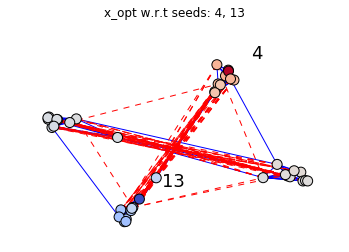

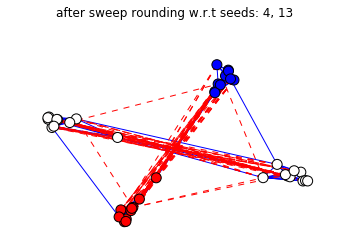

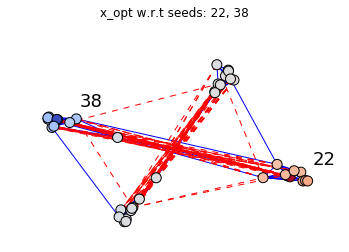

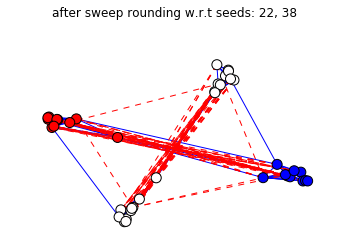

In [241]:
from matplotlib import pyplot as plt

kappa = 0.5

seeds_list = [
    [[4], [13]],
    [[22], [38]]
]

for seeds in seeds_list:
    x_opt, opt_val = query_graph(g, seeds, kappa=kappa, verbose=1)

    fig, ax = get_borderless_fig()
    nx.draw_networkx_nodes(g, pos, node_size=100, node_color=x_opt, cmap=plt.cm.coolwarm, ax=ax)
    draw_edges(g, pos, ax=ax)
    ax.set_title('x_opt w.r.t seeds: {}'.format(', '.join(map(str, flatten(seeds)))))
    for v in flatten(seeds):
        ax.text(pos[v][0]+0.04, pos[v][1]+0.04, str(v), fontsize=18)
    
    c1, c2, C, beta = sweep_on_x(g, x_opt, verbose=0)
    
    colors = np.zeros(g.number_of_nodes())
    colors[c1] = 1
    colors[c2] = -1
    fig, ax = get_borderless_fig()
    nx.draw_networkx_nodes(g, pos, node_size=100, node_color=colors, cmap=plt.cm.bwr, ax=ax)
    draw_edges(g, pos, ax=ax)
    ax.set_title('after sweep rounding w.r.t seeds: {}'.format(', '.join(map(str, flatten(seeds)))))
    

In [231]:
def sweep_on_x(g, x, verbose=0):
    ts = sorted(np.abs(x))[2:]  # avoid very small threshold
    sbr_list = [sbr_by_threshold(g, x, t) for t in ts]
    best_t = ts[np.argmin(sbr_list)]
    best_sbr = np.min(sbr_list)
    if verbose > 0:
        print('best_t:', best_t)

    c1, c2 = np.nonzero(x <= -best_t)[0], np.nonzero(x >= best_t)[0]
    C = np.nonzero(np.abs(x) >= best_t)[0]

    if verbose > 0:
        print('comm1:', c1)
        print('comm2:', c2)
        
    return c1, c2, C, best_sbr

# fig, ax = plt.subplots(1, 1)
# ax.plot(ts, sbr_list)



In [232]:
def run_one(g, seeds, kappa, target_comm, true_comms, true_groupings, check_bound=True):
    x_opt, opt_val = query_graph(g, seeds, kappa=kappa, verbose=0)
    c1, c2, C, min_sbr = sweep_on_x(g, x_opt, verbose=0)    
    prec_rec_f1_level1 = evaluate_level_1(
        g.number_of_nodes(), C, true_comms[target_comm]
    )[:-1]
    prec_rec_f1_level2 = evaluate_level_2(
        g.number_of_nodes(), c1, c2, C, true_groupings[target_comm]
    )[:-1]
    
    if check_bound:
        raise NotImplementedError('could be wrong, do not use it')
        print('beta=', min_sbr)
        print('upperbound sqrt(opt_val)=', np.sqrt(2 * opt_val))
        print('does upperbound hold?', min_sbr <= np.sqrt(2 * opt_val))
        print('-' * 10)
    return prec_rec_f1_level1 + prec_rec_f1_level2 + (len(C), len(c1), len(c2)) + (min_sbr, [v1, v2])


# effect of $\kappa$

test graph: 4 pairs of polarized communities

In [233]:
import random

random.seed(12345)
np.random.seed(12345)

size = 10
k = 4
g, true_comms, true_groupings = make_polarized_graphs(k, [(size, size) for i in range(k)])
A = nx.adj_matrix(g, weight='sign')

#communities 4
comm#1 sizes: 10 10
comm#2 sizes: 10 10
comm#3 sizes: 10 10
comm#4 sizes: 10 10


In [234]:
# using two seed nodes
n_reps = 1
target_comm = np.random.choice(len(true_comms))        
v1 = np.random.choice(true_groupings[target_comm][0])
v2 = np.random.choice(true_groupings[target_comm][1])

# bad example: 
# target_comm, v1, v2 = 2, 43, 56
# good example:
target_comm, v1, v2 = 3, 68, 77
seeds = [[v1], [v2]]


perf = []
for kappa in np.linspace(0, 1.0, 11):
    for i in range(n_reps):            
        res = run_one(g, seeds, kappa, target_comm, true_comms, true_groupings)
        perf.append((kappa, ) + res)
    


WARN: m less than n, problem likely degenerate
beta= 0.060498220640569395
upperbound sqrt(opt_val)= 0.41309106410376384
does upperbound hold? True
----------
WARN: m less than n, problem likely degenerate
beta= 0.060498220640569395
upperbound sqrt(opt_val)= 0.4128957272340836
does upperbound hold? True
----------
WARN: m less than n, problem likely degenerate
beta= 0.060498220640569395
upperbound sqrt(opt_val)= 0.45695678660132566
does upperbound hold? True
----------
WARN: m less than n, problem likely degenerate
beta= 0.060498220640569395
upperbound sqrt(opt_val)= 0.5442807947850661
does upperbound hold? True
----------
WARN: m less than n, problem likely degenerate
beta= 0.060498220640569395
upperbound sqrt(opt_val)= 0.6448377655048572
does upperbound hold? True
----------
WARN: m less than n, problem likely degenerate
beta= 0.060498220640569395
upperbound sqrt(opt_val)= 0.7494693861408457
does upperbound hold? True
----------
WARN: m less than n, problem likely degenerate
beta= 0.0

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


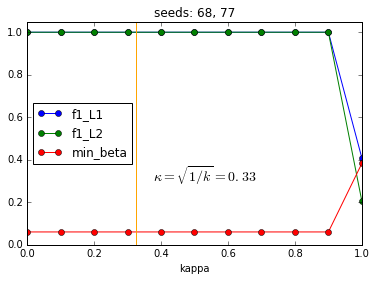

In [195]:
df = pd.DataFrame(
    perf,
    columns=['kappa', 'prec_L1', 'rec_L1', 'f1_L1',
             'prec_L2', 'rec_L2', 'f1_L2',
             'C-size', 'C1-size', 'C2-size',
             'min_beta', 'seeds']
)

agg_df = df[['kappa', 'f1_L1', 'f1_L2', 'min_beta']].groupby('kappa').mean()
agg_df.reset_index(level=0, inplace=True)

fig, ax = plt.subplots(1, 1)

seeds_str = ', '.join(map(str, flatten(seeds)))
agg_df.plot(
    x='kappa',
    y=['f1_L1', 'f1_L2', 'min_beta'],
    ylim=[0, 1.05],
    style='-o',
    title='seeds: {}'.format(seeds_str),
    ax=ax
)

theoretical_kappa = get_theoretical_kappa(
    true_comms[target_comm], 
    flatten(seeds),
    A
)

ax.axvline(x=theoretical_kappa, color='orange')
ax.text(
    theoretical_kappa+0.05,
    0.3,
    '$\kappa = \sqrt{{1 / k}}={:.2f}$'.format(theoretical_kappa),
    fontsize=14
)

fig.savefig('figs/effect-of-kappa/seeds-{}.png'.format(seeds_str))

# why the bad example (seed 43 and 56)

WARN: m less than n, problem likely degenerate
best_t 2.8098051023366772e-06
sbr of the ground truth 0.09285714285714286


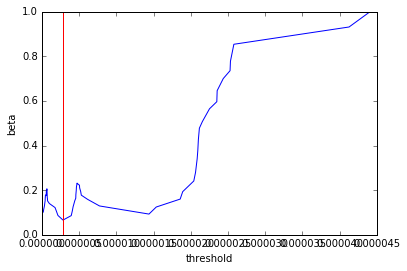

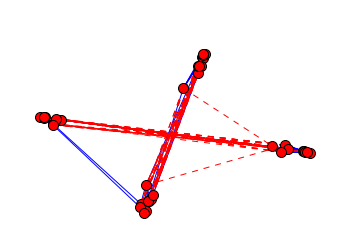

In [193]:
seeds = [[43], [56]]
kappa = 0.3
x_opt = query_graph(g, seeds, kappa=kappa, verbose=0)
ts = sorted(np.abs(x_opt))[2:]  # avoid very small threshold
sbr_list = [sbr_by_threshold(g, x_opt, t) for t in ts]

fig, ax = plt.subplots(1, 1)
ax.plot(ts, sbr_list)

best_t = ts[np.argmin(sbr_list)]
ax.axvline(best_t, color='red')
ax.set_xlabel('threshold')
ax.set_ylabel('beta')
fig.savefig('figs/dataset-issue-on-toy-graph/sweeping_plot.png')

best_sbr = np.min(sbr_list)
print('best_t', best_t)
C = (np.abs(x_opt) >= best_t).nonzero()[0]
print('sbr of the ground truth', sbr(A, *true_groupings[2]))

S1, S2, S, opt_beta = sweep_on_x(g, x_opt)
subg = g.subgraph(S)

fig, ax = get_borderless_fig()
subg = nx.convert_node_labels_to_integers(subg)
new_pos = signed_layout(subg)
nx.draw_networkx_nodes(subg, new_pos, node_size=100)
# draw_nodes(subg, new_pos, ax=ax)
draw_edges(subg, new_pos, ax=ax)
fig.savefig('figs/dataset-issue-on-toy-graph/detected_subgraph.png')